In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from config import pg_password, campaign_id, conversion_name

# hide sql alchemy warning in pandas
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

conn = psycopg2.connect(dbname="market_data", user = "postgres", host="localhost", password=pg_password, port = "5432")
cur = conn.cursor()


In [2]:
sql = f"""
select  
	ag.id as adgroup_id
	,ag.name as adgroup_name
	,ad.id as ad_id
	,ad.name as ad_name
	,fds.date as date
	,coalesce(impressions,0) as impressions
	,coalesce(link_clicks,0) as clicks
	,coalesce(spend,0) as spend
	,coalesce(video_q25,0) as video_q25
	,coalesce(video_q50,0) as video_q50
	,coalesce(video_q75,0) as video_q75
	,coalesce(video_q100,0) as video_q100
	,coalesce(count_1dc,0) as leads --one day lookback from click
	,split_part(split_part(split_part(ag.name,'SA~',2),'-',2),'_',1) as ag_audience --Audience name pulled from placement name
	,split_part(split_part(ag.name,'FF~',2),'_',2) as ag_placement --Meta placement pulled from placement name
	,split_part(split_part(ad.name,'_',2),'-',1) as creative_name --creative asset name pulled from ad name
	,split_part(split_part(ad.name,'_',2),'-',2) as creative_type --static or video 
from facebook.fact_daily_standard as fds
left join (
		select ad_id, account_id, date, count_1dc
		from facebook.fact_daily_actions 
		where campaign_id = {campaign_id} and action_name = '{conversion_name}') as fda
	on (fda.ad_id, fda.account_id, fda.date) = (fds.ad_id, fds.account_id, fds.date)
left join facebook.ads as ad
	on (ad.id, ad.account_id) = (fds.ad_id, fds.account_id)
left join facebook.adgroups as ag
	on (ag.id, ag.account_id) = (fds.adgroup_id, fds.account_id)
where fds.campaign_id = {campaign_id}
"""

Description

In [3]:
df = pd.read_sql(sql, conn)
df.describe()

,adgroup_id,ad_id,impressions,clicks,spend,video_q25,video_q50,video_q75,video_q100,leads
count,1.987000e+03,1.987000e+03,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000
mean,1.202034e+17,1.202038e+17,3824.255662,19.250629,108.991867,242.424258,109.099144,68.206844,46.070458,1.436839
std,8.109031e+07,9.746774e+11,4922.985586,23.287999,132.748992,579.484085,259.258874,158.092704,104.356780,2.099588
min,1.202034e+17,1.202034e+17,2.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.202034e+17,1.202034e+17,127.000000,1.000000,5.690000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.202034e+17,1.202036e+17,1117.000000,7.000000,39.230000,9.000000,4.000000,2.000000,2.000000,0.000000
75%,1.202034e+17,1.202036e+17,6793.500000,35.000000,224.360000,62.000000,29.000000,18.000000,13.000000,2.000000
max,1.202034e+17,1.202075e+17,21549.000000,110.000000,511.070000,3670.000000,1671.000000,964.000000,614.000000,12.000000


In [4]:
qualitative_fields = ['adgroup_id', 'adgroup_name', 'ad_id', 'ad_name', 'date','ag_audience', 'ag_placement', 'creative_name','creative_type']
def plot_scatter_matrix():
    
    axes = pd.plotting.scatter_matrix(df.drop(qualitative_fields, axis=1),figsize=(15,15), diagonal='kde', alpha=0.5)
    corr = df.drop(qualitative_fields, axis=1).corr().to_numpy()
    for i, j in zip(*plt.np.tril_indices_from(axes, k=-1)):
        axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')

Scatter matrix

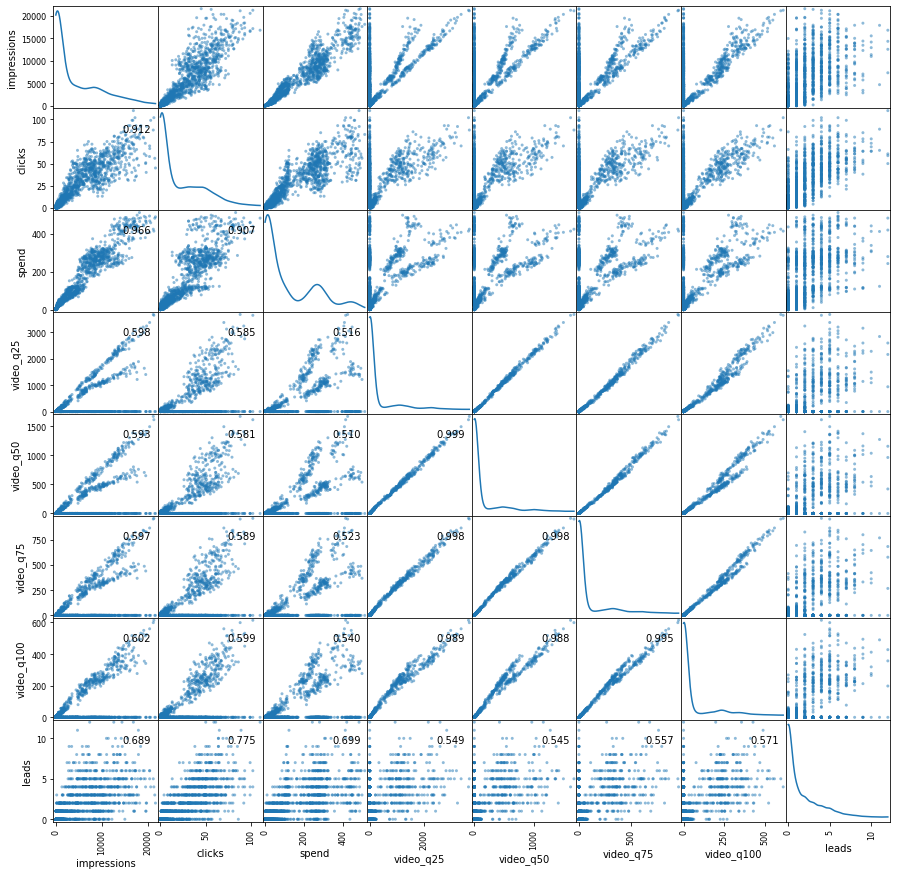

In [5]:
plot_scatter_matrix()

In [6]:
def aggregate_table(source_df=None, group=None, agg_fields=['leads','spend'], special_usage = None):
      
    agg_table =  source_df.groupby(by=group, as_index=False).agg({
        agg_fields[0]:'sum',
        agg_fields[1]:'sum'
    })

    if special_usage == None:
        return agg_table

    elif special_usage == 'for_bar_groups':
        return agg_table.index, agg_table[agg_fields[0]],agg_table[agg_fields[1]]

Comparative plots of top dimensions (aggregated)

Text(0.5, 1.0, 'creative_type')

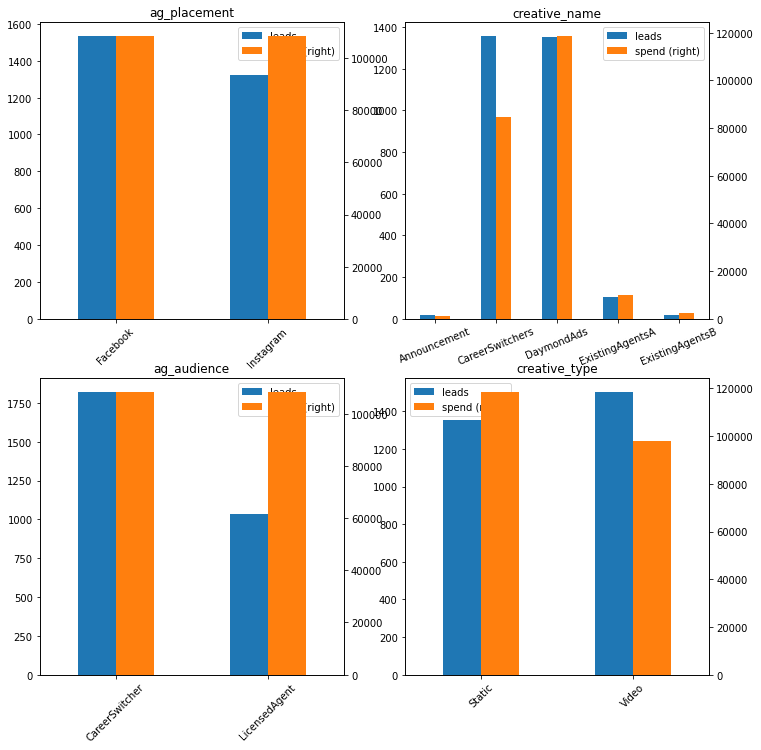

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))



# top placement by leads & spend
top_left = axes[0,0]
grouping_field = 'ag_placement'
tl_df = aggregate_table(df, grouping_field)
tl_df.plot(kind='bar', x=grouping_field, secondary_y=['spend'],ax=top_left, rot=45, xlabel="")
top_left.set_title(grouping_field)

# top ads by leads & spend
top_right = axes[0,1]
grouping_field = 'creative_name'
tr_df = aggregate_table(df, grouping_field)
tr_df.plot(kind='bar', x=grouping_field, secondary_y=['spend'],ax=top_right, rot=22.5, xlabel="")
top_right.set_title(grouping_field)

# top audiences by leads & spend
bottom_left = axes[1,0]
grouping_field = 'ag_audience'
bl_df = aggregate_table(df, grouping_field)
bl_df.plot(kind='bar', x=grouping_field, secondary_y=['spend'],ax=bottom_left, rot=45, xlabel="")
bottom_left.set_title(grouping_field)

# top formats by leads & spend
bottom_right = axes[1,1]
grouping_field = 'creative_type'
br_df = aggregate_table(df, grouping_field)
br_df.plot(kind='bar', x=grouping_field, secondary_y=['spend'],ax=bottom_right, rot=45, xlabel="")
bottom_right.set_title(grouping_field)

Adjusted CPA few of top few dimensions

In [8]:
import analysis as a
a.adjusted_cpa_view(tr_df)
a.adjusted_cpa_view(tl_df)
a.adjusted_cpa_view(bl_df)

Total average CPA is $75.86

     creative_name  leads      spend  Adjusted CPA  Percent Change
0     Announcement     19    1240.06     75.926227        0.000935
1  CareerSwitchers   1355   84608.06     87.972520        0.159741
2       DaymondAds   1354  118428.46     65.381999       -0.138069
3  ExistingAgentsA    107   10050.06     75.151667       -0.009276
4  ExistingAgentsB     20    2240.20     75.600226       -0.003362
------------------------------------------------------------


Total average CPA is $75.86

  ag_placement  leads      spend  Adjusted CPA  Percent Change
0     Facebook   1532  108282.82     81.847332        0.078993
1    Instagram   1323  108284.02     70.680692       -0.068217
------------------------------------------------------------


Total average CPA is $75.86

      ag_audience  leads      spend  Adjusted CPA  Percent Change
0  CareerSwitcher   1819  108283.43    104.520666        0.377896
1   LicensedAgent   1036  108283.41     59.529098       -0.21522

Boxplot of daily lead volume for each ad

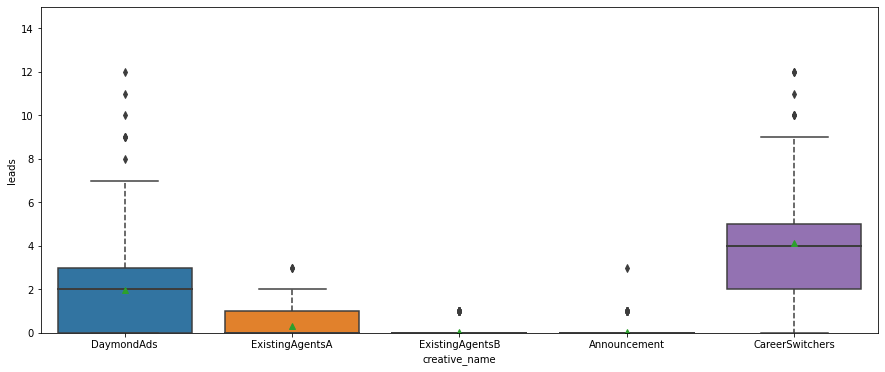

In [9]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(x=df['creative_name'], y=df['leads'], data=df,
            showmeans=True,
            whiskerprops={'linestyle': '--'},
            medianprops={'linewidth': 2})
plt.ylim(0,15)
plt.show()

ANOVA

In [10]:
qualitative_fields[5:]

['ag_audience', 'ag_placement', 'creative_name', 'creative_type']

In [11]:
agg_column = 'creative_name'
df_agg = df.groupby(by=agg_column, as_index=False).agg({'leads':'sum','clicks':'sum','spend':'sum'})
df_model = a.explode_to_samples(df_agg,agg_column,'clicks','leads')

In [12]:
model_formula =f'results ~ C({agg_column})'
model = smf.ols(model_formula, data=df_model).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)
df_agg['cvr'] = df_agg['leads'] / df_agg['clicks']
df_agg['cpa'] = df_agg['spend'] / df_agg['leads']
df_agg.head()


                       df       sum_sq   mean_sq          F        PR(>F)
C(creative_name)      4.0     4.015985  1.003996  14.556644  6.982227e-12
Residual          38246.0  2637.890893  0.068972        NaN           NaN


,creative_name,leads,clicks,spend,cvr,cpa
0,Announcement,19,210,1240.06,0.090476,65.266316
1,CareerSwitchers,1355,15767,84608.06,0.085939,62.441373
2,DaymondAds,1354,20751,118428.46,0.065250,87.465628
3,ExistingAgentsA,107,1272,10050.06,0.084119,93.925794
4,ExistingAgentsB,20,251,2240.20,0.079681,112.010000


In [13]:
model_df_nonagg = df[[agg_column, 'leads', 'clicks']]
model_formula =f'leads ~ clicks * C({agg_column})'
model = smf.ols(model_formula, data=model_df_nonagg).fit()
model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:                  leads   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     379.0
Date:                Tue, 16 Jul 2024   Prob (F-statistic):               0.00
Time:                        14:23:39   Log-Likelihood:                -3296.7
No. Observations:                1987   AIC:                             6613.
Df Residuals:                    1977   BIC:                             6669.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------